# Data Class

In [1]:
import random

class Sentiment:
    POSITIVE = "POSITIVE"
    NEGATIVE = "NEGATIVE" 

class Data:
    def __init__(self, tweet, replies, retweets, likes):
        self.tweet = tweet
        self.replies = replies
        self.retweets = retweets
        self.likes = likes
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.replies >= '200' or self.retweets >= '300' or self.likes >= '500':
            return Sentiment.POSITIVE
        else:
            return Sentiment.NEGATIVE
        
class DataContainer:
    def __init__(self, data):
        self.data = data
        
    def get_text(self):
        return [x.tweet for x in self.data]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.data]
        
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.data))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.data))
        negative_shrunk = negative[:len(positive)]
        self.data = positive + negative_shrunk
        random.shuffle(self.data)

# Load Data

In [2]:
import csv

data = []
i = 1
faulty_rows = 0
max_replies = 0
max_retweets = 0
max_likes = 0

with open(r"final_data.csv", encoding = 'utf-8') as f:    
    csvReader = csv.reader(f, delimiter=',', quotechar='"')
    for row in csvReader:
        if (i > 100000): #total tweets = 54243060 (faulty rows included)
            break
        if (len(row) == 4):
            if(row[1].isnumeric() and row[2].isnumeric() and row[3].isnumeric()):
                tweet = row[0]
                replies_count = row[1]
                retweets_count = row[2]
                likes_count = row[3]
                data.append(Data(tweet, replies_count, retweets_count, likes_count))
                #Find max replies, retweets, likes
                if (int(replies_count) > max_replies):
                    max_replies = int(replies_count)
                if (int(retweets_count) > max_retweets):
                    max_retweets = int(retweets_count)    
                if (int(likes_count) > max_likes):
                    max_likes = int(likes_count)
            else:
                print("Error: row " + str(i) + " was incorrect.")
                faulty_rows = faulty_rows + 1
        else:
            print("Error: row " + str(i) + " was not complete.")
            faulty_rows = faulty_rows + 1
        i = i + 1
f.close()

print(data[850].sentiment)
print(data[850].tweet)
print(f'\nData length: ' + str(len(data)))
print('Faulty rows: ' + str(faulty_rows))
print('Max replies: ' + str(max_replies))
print('Max retweets: ' + str(max_retweets))
print('Max likes: ' + str(max_likes))

NEGATIVE
@monicaonairtalk We stopped at the mask. Before corona the Lord led me, showed me a plot to inoculate the world with a plant-based vaccine. My husband thought I was nuts, then the news of the “virus” came. Praise God he could see. We don’t know his status, but he hasn’t served since March 2020

Data length: 100000
Faulty rows: 0
Max replies: 1908
Max retweets: 14453
Max likes: 49911


# Text Preprocessing

In [3]:
import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for i in range(0, len(data)):
    # Remove all the special characters (punctuation removal)
    document = re.sub(r'[^a-zA-Z0-9]', ' ', str(data[i].tweet))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    # Tokenization for stemming
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    data[i].tweet = document

print(data[850].tweet)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lambr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lambr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


monicaonairtalk we stopped at the mask before corona the lord led me showed me plot to inoculate the world with plant based vaccine my husband thought wa nut then the news of the virus came praise god he could see we don know his status but he hasn served since march 2020


# Prepare Data

In [4]:
from sklearn.model_selection import train_test_split

training, test = train_test_split(data, test_size=0.2, random_state=42)

train_container = DataContainer(training)
test_container = DataContainer(test)

train_container.evenly_distribute()
train_x = train_container.get_text()
train_y = train_container.get_sentiment()

test_container.evenly_distribute()
test_x = test_container.get_text()
test_y = test_container.get_sentiment()

print(train_y.count(Sentiment.POSITIVE))
print(train_y.count(Sentiment.NEGATIVE))

8137
8137


# Bag of words vectorization to TFIDF values

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np

vectorizer = TfidfVectorizer(max_features=1500, min_df=20, max_df=0.3, stop_words=stopwords.words('english'))

train_x_vectors = np.asarray(vectorizer.fit_transform(train_x).todense())
test_x_vectors = np.asarray(vectorizer.transform(test_x).todense())

print(test_x[0])
print(test_x_vectors[0])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lambr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


fund wa raised for corona with indian logo coordinator wa union government employee mail correspondence are from http co los84ntzwv 1 month government employee salary were forcefully taken now it belongs to private pmcaresfund scam no pm in indian history do this
[0. 0. 0. ... 0. 0. 0.]


# Plotting train vectors (different colors for each class)

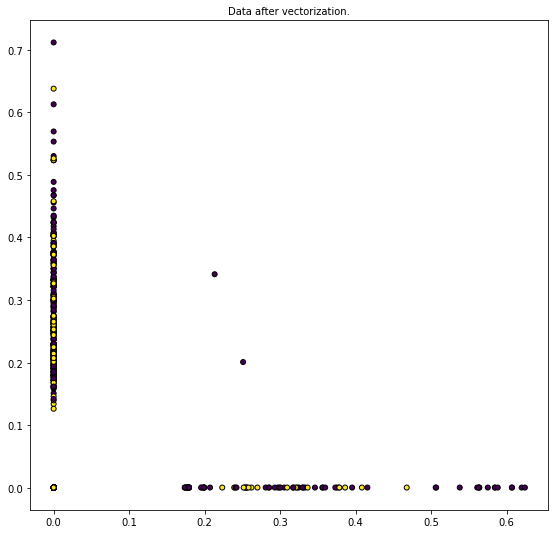

In [6]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles

plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

plt.subplot(111)
plt.title("Data after vectorization.", fontsize="medium")
train_y_numbers = []
for i in train_y:
    if i == "POSITIVE":
        train_y_numbers.append(1)
    else:
        train_y_numbers.append(0)
plt.scatter(train_x_vectors[:, 0], train_x_vectors[:, 1], marker="o", c=train_y_numbers, s=25, edgecolor="k")
fig = plt.gcf()
plt.show()

# Saving vectors figure

In [7]:
fig.savefig(r'10000_vectors.png')

# Classification

### Linear SVM

In [8]:
from sklearn.svm import LinearSVC

import timeit
start = timeit.default_timer()

clf_svm = LinearSVC(C=1, max_iter=10000, random_state=42)
clf_svm.fit(train_x_vectors, train_y)
svm_pred = clf_svm.predict(test_x_vectors)

stop = timeit.default_timer()
print('Time taken:', stop - start, ' sec.')

Time taken: 0.15135930000000108  sec.


### Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

import timeit
start = timeit.default_timer()

clf_dec = DecisionTreeClassifier(criterion='gini', splitter='random', random_state=42)
clf_dec.fit(train_x_vectors, train_y)
dec_pred = clf_dec.predict(test_x_vectors)

stop = timeit.default_timer()
print('Time taken:', stop - start, ' sec.')

Time taken: 19.318411200000003  sec.


### k-Nearest Neighbors (kNN)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

import timeit
start = timeit.default_timer()

clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
clf_knn.fit(train_x_vectors, train_y)
knn_pred = clf_knn.predict(test_x_vectors)

stop = timeit.default_timer()
print('Time taken:', stop - start, ' sec.')

Time taken: 2.170343899999999  sec.


### Naive Bayes

In [11]:
from sklearn.naive_bayes import GaussianNB

import timeit
start = timeit.default_timer()

clf_gnb = GaussianNB()
clf_gnb.fit(train_x_vectors, train_y)
gnb_pred = clf_gnb.predict(test_x_vectors)

stop = timeit.default_timer()
print('Time taken:', stop - start, ' sec.')

Time taken: 0.2727854000000036  sec.


### Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

import timeit
start = timeit.default_timer()

clf_log = LogisticRegression(solver='sag', random_state=42, n_jobs=-1)
clf_log.fit(train_x_vectors, train_y)
log_pred = clf_log.predict(test_x_vectors)

stop = timeit.default_timer()
print('Time taken:', stop - start, ' sec.')

Time taken: 5.496015700000001  sec.


### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

import timeit
start = timeit.default_timer()

clf_rnf = RandomForestClassifier(max_features='log2', n_estimators=200, criterion='gini', random_state=42, n_jobs=-1)
clf_rnf.fit(train_x_vectors, train_y)
rnf_pred = clf_rnf.predict(test_x_vectors)

stop = timeit.default_timer()
print('Time taken:', stop - start, ' sec.')

Time taken: 5.422781499999999  sec.


### Multi-layer Perceptron (MLP)

In [14]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPClassifier

import timeit
start = timeit.default_timer()

clf_mlp = MLPClassifier(max_iter=10, activation='relu', warm_start=True, verbose=False, random_state=42)
clf_mlp.fit(train_x_vectors, train_y)
mlp_pred = clf_mlp.predict(test_x_vectors)

stop = timeit.default_timer()
print('Time taken:', stop - start, ' sec.')

Time taken: 4.575048500000001  sec.


# Model Evaluation metrics

In [15]:
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('always')

print(f'\nLinear SVM:')
print(classification_report(test_y, svm_pred, zero_division=0))
print(f'\nDecision Tree:')
print(classification_report(test_y, dec_pred, zero_division=0))
print(f'\nk-Nearest Neighbors (kNN):')
print(classification_report(test_y, knn_pred, zero_division=0))
print(f'\nNaive Bayes:')
print(classification_report(test_y, gnb_pred, zero_division=0))
print(f'\nLogistic Regression:')
print(classification_report(test_y, log_pred, zero_division=0))
print(f'\nRandom Forest:')
print(classification_report(test_y, rnf_pred, zero_division=0))
print(f'\nMulti-layer Perceptron (MLP):')
print(classification_report(test_y, rnf_pred, zero_division=0))


Linear SVM:
              precision    recall  f1-score   support

    NEGATIVE       0.60      0.60      0.60      2045
    POSITIVE       0.60      0.61      0.61      2045

    accuracy                           0.60      4090
   macro avg       0.60      0.60      0.60      4090
weighted avg       0.60      0.60      0.60      4090


Decision Tree:
              precision    recall  f1-score   support

    NEGATIVE       0.59      0.59      0.59      2045
    POSITIVE       0.59      0.58      0.59      2045

    accuracy                           0.59      4090
   macro avg       0.59      0.59      0.59      4090
weighted avg       0.59      0.59      0.59      4090


k-Nearest Neighbors (kNN):
              precision    recall  f1-score   support

    NEGATIVE       0.56      0.72      0.63      2045
    POSITIVE       0.60      0.43      0.50      2045

    accuracy                           0.58      4090
   macro avg       0.58      0.58      0.57      4090
weighted avg     

In [16]:
print(train_y.count(Sentiment.POSITIVE))
print(train_y.count(Sentiment.NEGATIVE))

8137
8137


c:\users\lambr\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Testing our model

In [17]:
test_set = ['i am full of covid', "covid is not a virus", 'The pandemic brings economic crisis']
new_test = vectorizer.transform(test_set).toarray()

print(clf_svm.predict(new_test))
print(clf_dec.predict(new_test))
print(clf_knn.predict(new_test))
print(clf_gnb.predict(new_test))
print(clf_log.predict(new_test))
print(clf_rnf.predict(new_test))
print(clf_mlp.predict(new_test))

['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
['NEGATIVE' 'NEGATIVE' 'NEGATIVE']


c:\users\lambr\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Parameter tuning with Grid Search (made on 100.000 tweets)

In [18]:
#from sklearn.model_selection import GridSearchCV

# print('LinearSVC')
# parameters = {'max_iter':([10000, 20000, 50000]), 
#               'C':(1, 4, 8, 16, 32), 
#               'random_state':([42])} #C=1, max_iter=10000
# LinearSVC = LinearSVC()
# clf_svm_gs = GridSearchCV(LinearSVC, parameters, cv=5, n_jobs=-1)
# clf_svm_gs.fit(train_x_vectors, train_y)
# print(clf_svm_gs.best_params_)
# print()


# print('DecisionTreeClassifier')
# parameters = {'criterion':('gini', 'entropy'), 
#               'splitter':('best', 'random'), 
#               'random_state':([42])} criterion='gini', splitter='random'
# DecisionTreeClassifier = DecisionTreeClassifier()
# clf_dec_gs = GridSearchCV(DecisionTreeClassifier, parameters, cv=5, n_jobs=-1)
# clf_dec_gs.fit(train_x_vectors, train_y)                                             
# print(clf_dec_gs.best_params_)
# print()


# print('KNeighborsClassifier')
# parameters = {'n_neighbors':(5, 10, 20, 30 ,40), 
#               'weights':('uniform', 'distance')} #n_neighbors=5, weights='distance'
# KNeighborsClassifier = KNeighborsClassifier()
# clf_knn_gs = GridSearchCV(KNeighborsClassifier, parameters, cv=5, n_jobs=-1)
# clf_knn_gs.fit(train_x_vectors, train_y)
# print(clf_knn_gs.best_params_)
# print()              


# print('GaussianNB')
# parameters = {}
# GaussianNB = GaussianNB()
# clf_gnb_gs = GridSearchCV(GaussianNB, parameters, cv=5, n_jobs=-1)
# clf_gnb_gs.fit(train_x_vectors, train_y)
# print(clf_gnb_gs.best_params_)
# print()


# print('LogisticRegression')
# parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'), 
#               'random_state':([42])} #solver='sag'
# LogisticRegression = LogisticRegression()
# clf_log_gs = GridSearchCV(LogisticRegression, parameters, cv=5, n_jobs=-1)
# clf_log_gs.fit(train_x_vectors, train_y)
# print(clf_log_gs.best_params_)
# print()


# print('RandomForestClassifier')
# parameters = {'max_features':('auto', 'sqrt', 'log2'), 
#               'n_estimators':(10, 20, 50, 80, 100, 200), 
#               'criterion':('gini', 'entropy'), 
#               'random_state':([42])} #max_features='log2', n_estimators=200, criterion='gini'
# RandomForestClassifier = RandomForestClassifier()
# clf_rnf_gs = GridSearchCV(RandomForestClassifier, parameters, cv=5, n_jobs=-1)
# clf_rnf_gs.fit(train_x_vectors, train_y)
# print(clf_rnf_gs.best_params_)
# print()


# print('MLPClassifier')
# parameters = {'warm_start':('True', 'False'), 
#               'activation':('identity', 'logistic', 'tanh', 'relu'),
#               'random_state':([42]),
#               'max_iter':(10, 20, 30, 40, 50, 60)} #max_iter=10, warm_start=True, activation='relu'
# MLPClassifier = MLPClassifier()
# clf_mlp_gs = GridSearchCV(MLPClassifier, parameters, cv=5, n_jobs=-1)
# clf_mlp_gs.fit(train_x_vectors, train_y)
# print(clf_mlp_gs.best_params_)
# print()

c:\users\lambr\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Plotting the results

c:\users\lambr\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


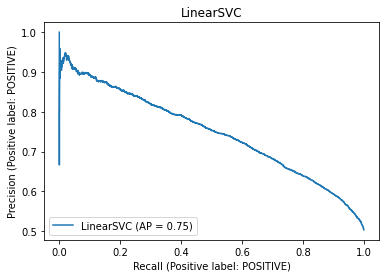

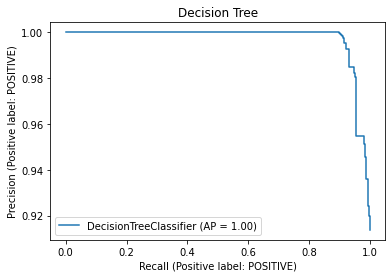

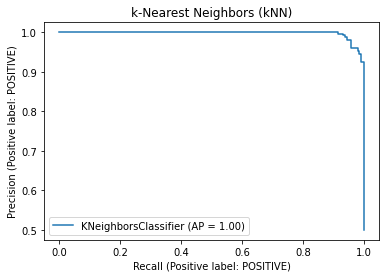

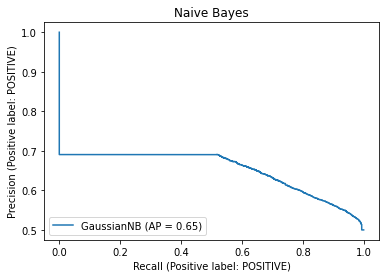

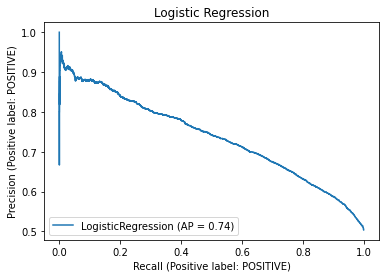

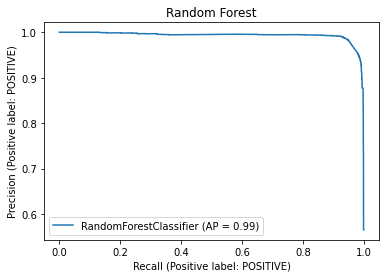

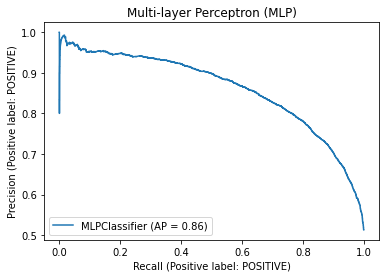

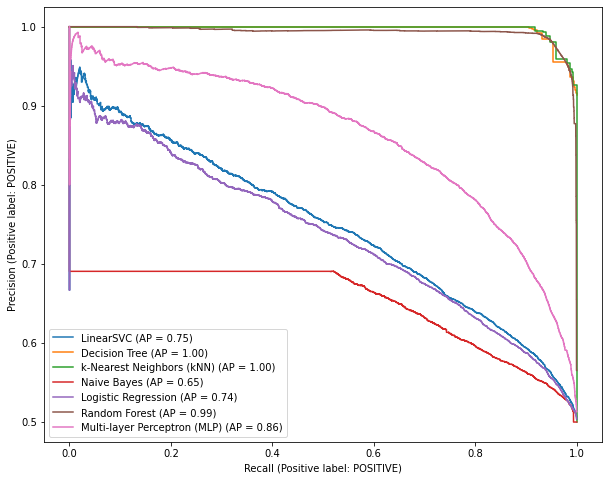

In [19]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

# Sigle plots
display1 = PrecisionRecallDisplay.from_estimator(clf_svm, train_x_vectors, train_y)
_ = display1.ax_.set_title("LinearSVC")
display2 = PrecisionRecallDisplay.from_estimator(clf_dec, train_x_vectors, train_y)
_ = display2.ax_.set_title("Decision Tree")
display3 = PrecisionRecallDisplay.from_estimator(clf_knn, train_x_vectors, train_y)
_ = display3.ax_.set_title("k-Nearest Neighbors (kNN)")
display4 = PrecisionRecallDisplay.from_estimator(clf_gnb, train_x_vectors, train_y)
_ = display4.ax_.set_title("Naive Bayes")
display5 = PrecisionRecallDisplay.from_estimator(clf_log, train_x_vectors, train_y)
_ = display5.ax_.set_title("Logistic Regression")
display6 = PrecisionRecallDisplay.from_estimator(clf_rnf, train_x_vectors, train_y)
_ = display6.ax_.set_title("Random Forest")
display7 = PrecisionRecallDisplay.from_estimator(clf_mlp, train_x_vectors, train_y)
_ = display7.ax_.set_title("Multi-layer Perceptron (MLP)")

# Combined plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

display1.plot(ax=ax, name = "LinearSVC")
display2.plot(ax=ax, name = "Decision Tree")
display3.plot(ax=ax, name = "k-Nearest Neighbors (kNN)")
display4.plot(ax=ax, name = "Naive Bayes")
display5.plot(ax=ax, name = "Logistic Regression")
display6.plot(ax=ax, name = "Random Forest")
display7.plot(ax=ax, name = "Multi-layer Perceptron (MLP)")

plt.show()

# Saving figure

In [20]:
fig.savefig(r'10000_tweets_precision_recall.png')

# Saving Model

### Save model

In [21]:
import pickle

all_clf = [clf_svm, clf_dec, clf_knn, clf_gnb, clf_log, clf_rnf, clf_mlp]
with open(r'sentiment_classifier_10000_tweets.pkl', 'wb') as f:
    pickle.dump(all_clf, f)
f.close()

### Load model

In [22]:
with open(r'sentiment_classifier_10000_tweets.pkl', 'rb') as f:
    classification_model = pickle.load(f)

### Use model

In [23]:
test_set = ['very full of covid', "covid is a virus", 'the pandemic brings economic crisis']
new_test = vectorizer.transform(test_set).toarray()

print(classification_model)
print()
print()
print(classification_model[0].predict(new_test))
print(classification_model[1].predict(new_test))
print(classification_model[2].predict(new_test))
print(classification_model[3].predict(new_test))
print(classification_model[4].predict(new_test))
print(classification_model[5].predict(new_test))
print(classification_model[6].predict(new_test))

[LinearSVC(C=1, max_iter=10000, random_state=42), DecisionTreeClassifier(random_state=42, splitter='random'), KNeighborsClassifier(n_jobs=-1, weights='distance'), GaussianNB(), LogisticRegression(n_jobs=-1, random_state=42, solver='sag'), RandomForestClassifier(max_features='log2', n_estimators=200, n_jobs=-1,
                       random_state=42), MLPClassifier(max_iter=10, random_state=42, warm_start=True)]


['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
['NEGATIVE' 'NEGATIVE' 'NEGATIVE']
